# Spectrogram setup in Python

### Import key libraries and setup

In [3]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import NMF
import random

### Import all ERP Trials for P35 - Category Faces, Session 1 - Channel 1 + Channel 2 separately

In [7]:
p35_chn_01 = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp/P35_specgram/P35-ses-01-chn-01-Faces.csv"
p35_chn_02 = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp/P35_specgram/P35-ses-01-chn-02-Faces.csv"

In [8]:
p35_chn_01_trials = np.loadtxt(fname = p35_chn_01, skiprows = 1, delimiter = ",")
p35_chn_02_trials = np.loadtxt(fname = p35_chn_02, skiprows = 1, delimiter = ",")
print(p35_chn_01_trials.shape)
print(p35_chn_02_trials.shape)

(83, 1500)
(83, 1500)


**Check:** *As expected we have 83 trials for the faces category and 1500 individual millisecond timepoints*

### Extract a Single trial to plot the relevant spectrogram

In [9]:
p35_chn_01_samp = p35_chn_01_trials[2]
p35_chn_01_samp.shape

(1500,)

**Check:** *As expected we have 1 trial for the faces category and 1500 individual millisecond timepoints*

In [10]:
def samp_idx_without_replace(np_arr, samp_prop=0.5):
    tot_num_rows = np_arr.shape[0]
    samp_num_rows = int(np.floor(tot_num_rows * samp_prop))
    #print(tot_num_rows)
    #print(samp_num_rows)    
    # TODO: technically we don't need to sort for operational purposes. Consider removing this
    return sorted(random.sample(range(tot_num_rows), samp_num_rows))

In [11]:
test_sampling = samp_idx_without_replace(np_arr=p35_chn_01_trials, samp_prop=0.2)

### Produce the Spectrogram for a Single Trial

In [12]:
def erp_gen_spectrogram(x, fs = 1e3, window = 'hann', nperseg = 128, noverlap = 96):
    """Generate the spectrogram and return the log of the modulus"""
    f, t, Sxx = signal.spectrogram(x = x, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)
    return f, t, Sxx

In [17]:
spec_out = erp_gen_spectrogram(x = p35_chn_01_samp)

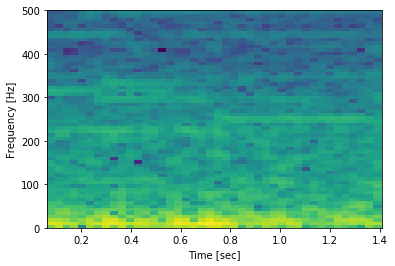

In [18]:
plt.pcolormesh(spec_out[1], spec_out[0], np.log(spec_out[2]))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [29]:
Sxx = spec_out[2]
filter_rows_idx = range(65)
Sxx[filter_rows_idx].shape

(65, 43)

In [10]:
print("spectrogram", spec_out[2].shape, sep = ": ")
print("t", spec_out[0].shape, sep = ": ")
print("f", spec_out[1].shape, sep = ": ")

spectrogram: (65, 43)
t: (65,)
f: (43,)


In [11]:
test = [erp_gen_spectrogram(x = p35_chn_01_trials[idx])[2] for idx in range(10)]
len(test)

10

In [12]:
b = np.hstack(test)
b.shape

(65, 430)

# Get combined spectrogram for a range of trials

In [13]:
def specgram_trials(arr_all_trials, samp_prop):
    """Produce a combined list of spectrograms concatenated by frequency (horizontally)"""
    samp_idx = samp_idx_without_replace(np_arr=arr_all_trials, samp_prop=samp_prop)
    trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx])[2] for idx in samp_idx]
    comb_specgram = np.hstack(trial_specgrams)
    return comb_specgram

## Perform NMF to decompose the spectrogram V as W times H

In [14]:
def nmf_specgrams(comb_specgram, n_components=5, init='random', random_state=0, beta_loss='itakura-saito', solver = 'mu'):
    model = NMF(n_components=n_components, init=init, random_state=random_state, beta_loss=beta_loss, solver=solver)
    W = model.fit_transform(X=comb_specgram)
    H = model.components_
    return W, H

## Wrap it into a single function

In [15]:
def nmf_wrapper(arr_all_trials, samp_prop=0.5, n_components=5, init='random', random_state=0, beta_loss='itakura-saito', solver = 'mu'):
    comb_specgram = specgram_trials(arr_all_trials=arr_all_trials, samp_prop=samp_prop)
    W, H = nmf_specgrams(comb_specgram, n_components=n_components, init=init, random_state=random_state, beta_loss=beta_loss, solver=solver)
    print("V", comb_specgram.shape, sep = ": ")
    print("W", W.shape, sep = ": ")
    print("H", H.shape, sep = ": ")
    return comb_specgram, W, H

### Plot the "basis" vectors i.e. columns of W

In [17]:
def plotW(W, log=True):
    if log:
        W_plt = np.log(W)
    else:
        W_plt = W
    n_components = W.shape[1]    
    for n in range(W.shape[1]):
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.plot(W_plt[:,n])
        plt.ylim(-2, W_plt.max())
        plt.xlim(0, W_plt.shape[0])
        plt.ylabel('Component %d' % n)

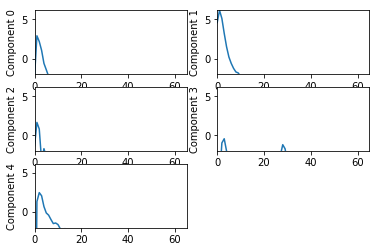

In [28]:
plotW(W = W1, log=True)

### Plot the rows of H i.e. the temporal activations

In [19]:
def plotH(H, log=False):
    if log:
        H_plt = np.log(H)
    else:
        H_plt = H
    n_components = H.shape[0]    
    for n in range(H.shape[0]):
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.plot(H[n])
        plt.ylim(0, H.max())
        plt.xlim(0, H.shape[1])
        plt.ylabel('Component %d' % n)

# Channel 1 - P35, Faces, Session 1

In [34]:
43*83*0.7

2498.2999999999997

In [32]:
V1, W1, H1 = nmf_wrapper(arr_all_trials=p35_chn_01_trials, samp_prop=0.7, n_components=5, 
                         init='random', random_state=0, beta_loss='itakura-saito', solver = 'mu')

V: (65, 2494)
W: (65, 5)
H: (5, 2494)


/Users/shamindras/anaconda/envs/sklearnprod1/lib/python3.6/site-packages/sklearn/decomposition/nmf.py:1035: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


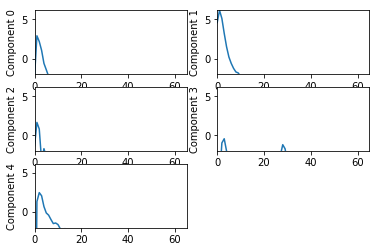

In [22]:
plotW(W = W1, log=True)

/Users/shamindras/anaconda/envs/sklearnprod1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


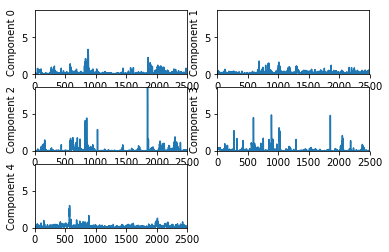

In [31]:
plotH(H = H1, log=True)

# Channel 2 - P35, Faces, Session 1

In [24]:
V2, W2, H2 = nmf_wrapper(arr_all_trials=p35_chn_02_trials, samp_prop=0.7, n_components=5, 
                         init='random', random_state=0, beta_loss='itakura-saito', solver = 'mu')

V: (65, 2494)
W: (65, 5)
H: (5, 2494)


/Users/shamindras/anaconda/envs/sklearnprod1/lib/python3.6/site-packages/sklearn/decomposition/nmf.py:1035: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


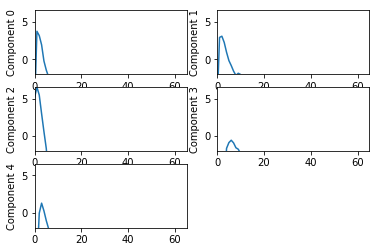

In [25]:
plotW(W = W2, log=True)

/Users/shamindras/anaconda/envs/sklearnprod1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


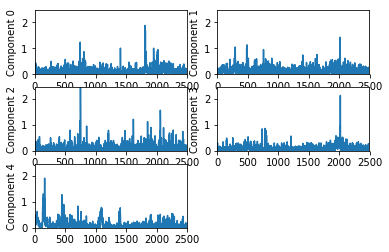

In [30]:
plotH(H = H2, log=True)

### Next Steps:

* How to interpret these results clearly for a single trial?
* How to determine the number of components in the NMF?
* How to combine results across trials?
* How to capture the uncertainty in this measure? 